# SAX circuit simulator

[SAX](https://flaport.github.io/sax/) is a circuit solver written in JAX, writing your component models in SAX enables you not only to get the function values but the gradients, this is useful for circuit optimization.

This tutorial has been adapted from SAX tutorial.

Note that SAX does not work on Windows, so if you use windows you'll need to run from [WSL](https://docs.microsoft.com/en-us/windows/wsl/) or using docker.

You can install sax with pip

```
! pip install sax
```

In [1]:
import gdsfactory as gf
import gdsfactory.simulation.sax as gs
import gdsfactory.simulation.modes as gm
import matplotlib.pyplot as plt
import sax

2022-06-30 06:15:08.394 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.12.4


2022-06-30 06:15:10.114 | INFO     | gdsfactory.simulation.gmeep:<module>:28 - Meep '1.23.0' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep']


Using MPI version 4.0, 1 processes


## Scatter *dictionaries*

The core datastructure for specifying scatter parameters in SAX is a dictionary... more specifically a dictionary which maps a port combination (2-tuple) to a scatter parameter (or an array of scatter parameters when considering multiple wavelengths for example). Such a specific dictionary mapping is called ann `SDict` in SAX (`SDict ≈ Dict[Tuple[str,str], float]`).

Dictionaries are in fact much better suited for characterizing S-parameters than, say, (jax-)numpy arrays due to the inherent sparse nature of scatter parameters. Moreover, dictionaries allow for string indexing, which makes them much more pleasant to use in this context.

```
o2            o3
   \        /
    ========
   /        \
o1            o4
```

In [2]:
coupling = 0.5
kappa = coupling**0.5
tau = (1 - coupling) ** 0.5
coupler_dict = {
    ("o1", "o4"): tau,
    ("o4", "o1"): tau,
    ("o1", "o3"): 1j * kappa,
    ("o3", "o1"): 1j * kappa,
    ("o2", "o4"): 1j * kappa,
    ("o4", "o2"): 1j * kappa,
    ("o2", "o3"): tau,
    ("o3", "o2"): tau,
}
coupler_dict

{('o1', 'o4'): 0.7071067811865476,
 ('o4', 'o1'): 0.7071067811865476,
 ('o1', 'o3'): 0.7071067811865476j,
 ('o3', 'o1'): 0.7071067811865476j,
 ('o2', 'o4'): 0.7071067811865476j,
 ('o4', 'o2'): 0.7071067811865476j,
 ('o2', 'o3'): 0.7071067811865476,
 ('o3', 'o2'): 0.7071067811865476}

 it can still be tedious to specify every port in the circuit manually. SAX therefore offers the `reciprocal` function, which auto-fills the reverse connection if the forward connection exist. For example:

In [3]:
coupler_dict = sax.reciprocal(
    {
        ("o1", "o4"): tau,
        ("o1", "o3"): 1j * kappa,
        ("o2", "o4"): 1j * kappa,
        ("o2", "o3"): tau,
    }
)

coupler_dict

{('o1', 'o4'): 0.7071067811865476,
 ('o1', 'o3'): 0.7071067811865476j,
 ('o2', 'o4'): 0.7071067811865476j,
 ('o2', 'o3'): 0.7071067811865476,
 ('o4', 'o1'): 0.7071067811865476,
 ('o3', 'o1'): 0.7071067811865476j,
 ('o4', 'o2'): 0.7071067811865476j,
 ('o3', 'o2'): 0.7071067811865476}

## Parametrized Models

Constructing such an `SDict` is easy, however, usually we're more interested in having parametrized models for our components. To parametrize the coupler `SDict`, just wrap it in a function to obtain a SAX `Model`, which is a keyword-only function mapping to an `SDict`:

In [4]:
def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    return sax.reciprocal(
        {
            ("o1", "o4"): tau,
            ("o1", "o3"): 1j * kappa,
            ("o2", "o4"): 1j * kappa,
            ("o2", "o3"): tau,
        }
    )


coupler(coupling=0.3)

{('o1', 'o4'): 0.8366600265340756,
 ('o1', 'o3'): 0.5477225575051661j,
 ('o2', 'o4'): 0.5477225575051661j,
 ('o2', 'o3'): 0.8366600265340756,
 ('o4', 'o1'): 0.8366600265340756,
 ('o3', 'o1'): 0.5477225575051661j,
 ('o4', 'o2'): 0.5477225575051661j,
 ('o3', 'o2'): 0.8366600265340756}

In [5]:
def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )

## Component Models

### Waveguide model

You can create a dispersive waveguide model in SAX.

Lets compute the effective index `neff` and group index `ng` for a 1550nm 500nm straight waveguide

In [6]:
m = gm.find_mode_dispersion(wavelength=1.55)
print(m.neff, m.ng)

2.358261301613378 4.276254924524516


In [7]:
straight_sc = gf.partial(gs.models.straight, neff=m.neff, ng=m.ng)

(-1.0, 1.0)

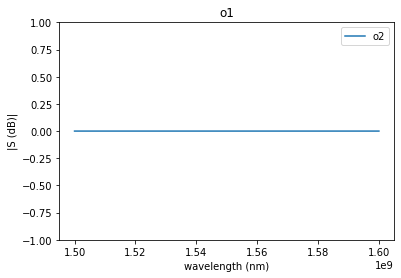

In [8]:
gs.plot_model(straight_sc)
plt.ylim(-1, 1)

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='angle (rad)'>

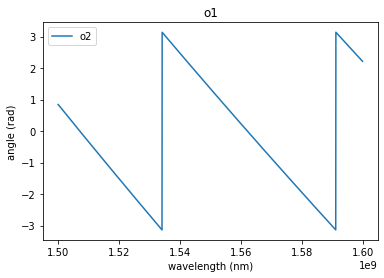

In [9]:
gs.plot_model(straight_sc, phase=True)

### Coupler model

In [10]:
gm.find_coupling_vs_gap?

In [11]:
df = gm.find_coupling_vs_gap()
df

  0%|          | 0/12 [00:00<?, ?it/s]

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/types.py:229: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(val, dtype=cls.inner_type)


,gap,ne,no,lc,dn
0,0.200000,2.457895,2.437607,38.198501,0.020289
1,0.218182,2.459031,2.441121,43.271686,0.017910
2,0.236364,2.452194,2.437659,53.321719,0.014534
3,0.254545,2.451947,2.439549,62.508167,0.012398
4,0.272727,2.451248,2.441058,76.057917,0.010190
5,0.290909,2.451498,2.442325,84.491808,0.009172
6,0.309091,2.449446,2.441517,97.740241,0.007929
7,0.327273,2.447256,2.440698,118.174593,0.006558
8,0.345455,2.451724,2.446248,141.521577,0.005476
9,0.363636,2.451128,2.446210,157.605308,0.004917


For a 200nm gap the effective index difference `dn` is `0.02`, which means that there is 100% power coupling over 38.2um

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

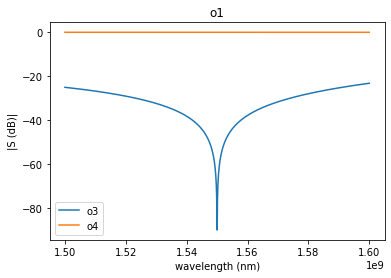

In [12]:
coupler_sc = gf.partial(gs.models.coupler, dn=0.02, length=0, coupling0=0)
gs.plot_model(coupler_sc)

If we ignore the coupling from the bend `coupling0 = 0` we know that for a 3dB coupling we need half of the `lc` length, which is the length needed to coupler `100%` of power.

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

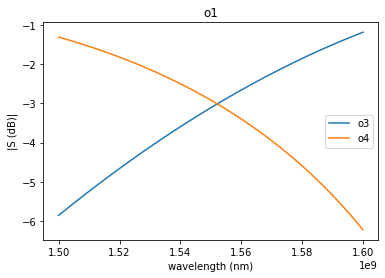

In [13]:
coupler_sc = gf.partial(gs.models.coupler, dn=0.02, length=38.2 / 2, coupling0=0)
gs.plot_model(coupler_sc)

### FDTD Sparameters model

You can also fit a model from Sparameter FDTD simulation data.

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

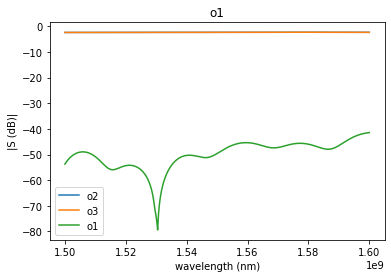

In [14]:
from gdsfactory.simulation.get_sparameters_path import get_sparameters_path_lumerical

filepath = get_sparameters_path_lumerical(gf.c.mmi1x2)
mmi1x2 = gf.partial(gs.read.sdict_from_csv, filepath=filepath)
gs.plot_model(mmi1x2)

## Circuit Models

You can combine component models into a circuit using `sax.circuit`, which basically creates a new `Model` function:

Lets define an [MZI interferometer](https://en.wikipedia.org/wiki/Mach%E2%80%93Zehnder_interferometer)

- two couplers (rgt, lft) right and left
- two waveguides (top, bot)

```
           _________
          |  top    |
          |         |
    lft===|         |===rgt
          |         |
          |_________|
             bot

               o1    top   o2
                 ----------
o2            o3           o2            o3
   \        /                 \        /
    ========                   ========
   /        \                 /        \
o1     lft    04           o1    rgt     04
                 ----------
               o1   bot    o2
```

In [15]:
waveguide = straight_sc
coupler = coupler_sc

mzi = sax.circuit(
    instances={
        "lft": coupler,
        "top": waveguide,
        "bot": waveguide,
        "rgt": coupler,
    },
    connections={
        "lft,o4": "bot,o1",
        "bot,o2": "rgt,o1",
        "lft,o3": "top,o1",
        "top,o2": "rgt,o2",
    },
    ports={
        "o1": "lft,o1",
        "o2": "lft,o2",
        "o4": "rgt,o4",
        "o3": "rgt,o3",
    },
)

The `circuit` function just creates a similar function as we created for the waveguide and the coupler, but instead of taking parameters directly it takes parameter *dictionaries* for each of the instances in the circuit. The keys in these parameter dictionaries should correspond to the keyword arguments of each individual subcomponent.

You can simulate the MZI

In [16]:
%time mzi()

{('o1', 'o1'): DeviceArray(0.+0.j, dtype=complex64),
 ('o1', 'o2'): DeviceArray(0.+0.j, dtype=complex64),
 ('o2', 'o1'): DeviceArray(0.+0.j, dtype=complex64),
 ('o2', 'o2'): DeviceArray(0.+0.j, dtype=complex64),
 ('o4', 'o4'): DeviceArray(0.+0.j, dtype=complex64),
 ('o4', 'o3'): DeviceArray(0.+0.j, dtype=complex64),
 ('o4', 'o1'): DeviceArray(0.00491904+0.02174363j, dtype=complex64),
 ('o4', 'o2'): DeviceArray(0.97511-0.22059795j, dtype=complex64),
 ('o3', 'o4'): DeviceArray(0.+0.j, dtype=complex64),
 ('o3', 'o3'): DeviceArray(0.+0.j, dtype=complex64),
 ('o3', 'o1'): DeviceArray(0.97511-0.22059795j, dtype=complex64),
 ('o3', 'o2'): DeviceArray(0.00491904+0.02174363j, dtype=complex64),
 ('o1', 'o4'): DeviceArray(0.00491904+0.02174363j, dtype=complex64),
 ('o1', 'o3'): DeviceArray(0.97511-0.22059795j, dtype=complex64),
 ('o2', 'o4'): DeviceArray(0.97511-0.22059795j, dtype=complex64),
 ('o2', 'o3'): DeviceArray(0.00491904+0.02174363j, dtype=complex64)}

In [17]:
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt  # plotting

mzi2 = jax.jit(mzi)

In [18]:
%time mzi2()

{('o1', 'o1'): DeviceArray(0.+0.j, dtype=complex64),
 ('o1', 'o2'): DeviceArray(0.+0.j, dtype=complex64),
 ('o1', 'o3'): DeviceArray(0.97511-0.22059795j, dtype=complex64),
 ('o1', 'o4'): DeviceArray(0.00491904+0.02174363j, dtype=complex64),
 ('o2', 'o1'): DeviceArray(0.+0.j, dtype=complex64),
 ('o2', 'o2'): DeviceArray(0.+0.j, dtype=complex64),
 ('o2', 'o3'): DeviceArray(0.00491904+0.02174363j, dtype=complex64),
 ('o2', 'o4'): DeviceArray(0.97511-0.22059795j, dtype=complex64),
 ('o3', 'o1'): DeviceArray(0.97511-0.22059795j, dtype=complex64),
 ('o3', 'o2'): DeviceArray(0.00491904+0.02174363j, dtype=complex64),
 ('o3', 'o3'): DeviceArray(0.+0.j, dtype=complex64),
 ('o3', 'o4'): DeviceArray(0.+0.j, dtype=complex64),
 ('o4', 'o1'): DeviceArray(0.00491904+0.02174363j, dtype=complex64),
 ('o4', 'o2'): DeviceArray(0.97511-0.22059795j, dtype=complex64),
 ('o4', 'o3'): DeviceArray(0.+0.j, dtype=complex64),
 ('o4', 'o4'): DeviceArray(0.+0.j, dtype=complex64)}

In [19]:
mzi(top={"length": 25.0}, btm={"length": 15.0})

{('o1', 'o1'): DeviceArray(0.+0.j, dtype=complex64),
 ('o1', 'o2'): DeviceArray(0.+0.j, dtype=complex64),
 ('o2', 'o1'): DeviceArray(0.+0.j, dtype=complex64),
 ('o2', 'o2'): DeviceArray(0.+0.j, dtype=complex64),
 ('o4', 'o4'): DeviceArray(0.+0.j, dtype=complex64),
 ('o4', 'o3'): DeviceArray(0.+0.j, dtype=complex64),
 ('o4', 'o1'): DeviceArray(-0.36328408+0.3874847j, dtype=complex64),
 ('o4', 'o2'): DeviceArray(0.6011225-0.597103j, dtype=complex64),
 ('o3', 'o4'): DeviceArray(0.+0.j, dtype=complex64),
 ('o3', 'o3'): DeviceArray(0.+0.j, dtype=complex64),
 ('o3', 'o1'): DeviceArray(0.6011225-0.597103j, dtype=complex64),
 ('o3', 'o2'): DeviceArray(0.38991326-0.36067626j, dtype=complex64),
 ('o1', 'o4'): DeviceArray(-0.36328408+0.3874847j, dtype=complex64),
 ('o1', 'o3'): DeviceArray(0.6011225-0.597103j, dtype=complex64),
 ('o2', 'o4'): DeviceArray(0.6011225-0.597103j, dtype=complex64),
 ('o2', 'o3'): DeviceArray(0.38991326-0.36067626j, dtype=complex64)}

In [20]:
wl = jnp.linspace(1.51, 1.59, 1000)
%time S = mzi(wl=wl, top={"length": 25.0}, btm={"length": 15.0})

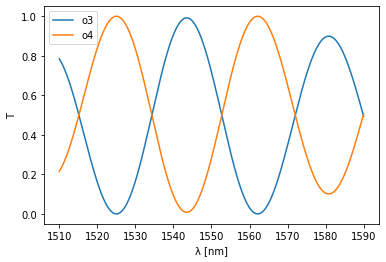

In [21]:
plt.plot(wl * 1e3, abs(S["o1", "o3"]) ** 2, label="o3")
plt.plot(wl * 1e3, abs(S["o1", "o4"]) ** 2, label="o4")
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()

## Optimization

You can optimize an MZI to get T=0 at 1550nm.
To do this, you need to define a loss function for the circuit at 1550nm.
This function should take the parameters that you want to optimize as positional arguments:

In [22]:
@jax.jit
def loss(delta_length):
    S = mzi(wl=1.55, top={"length": 15.0 + delta_length}, btm={"length": 15.0})
    return (abs(S["o1", "o4"]) ** 2).mean()

In [23]:
%time loss(10.0)

DeviceArray(0.28211972, dtype=float32)

You can use this loss function to define a grad function which works on the parameters of the loss function:

In [24]:
grad = jax.jit(
    jax.grad(
        loss,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

Next, you need to define a JAX optimizer, which on its own is nothing more than three more functions:

1. an initialization function with which to initialize the optimizer state
2. an update function which will update the optimizer state (and with it the model parameters).
3. a function with the model parameters given the optimizer state.

In [25]:
initial_delta_length = 10.0
optim_init, optim_update, optim_params = opt.adam(step_size=0.1)
optim_state = optim_init(initial_delta_length)

In [26]:
def train_step(step, optim_state):
    settings = optim_params(optim_state)
    lossvalue = loss(settings)
    gradvalue = grad(settings)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state

In [27]:
import tqdm

range_ = tqdm.trange(300)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:04<?, ?it/s, loss=0.282120]

  0%|          | 1/300 [00:04<23:28,  4.71s/it, loss=0.282120]

  0%|          | 1/300 [00:12<23:28,  4.71s/it, loss=0.007135]

  1%|          | 2/300 [00:12<33:44,  6.79s/it, loss=0.007135]

  1%|          | 2/300 [00:12<33:44,  6.79s/it, loss=0.085998]

  1%|          | 2/300 [00:13<33:44,  6.79s/it, loss=0.142725]

  1%|          | 2/300 [00:13<33:44,  6.79s/it, loss=0.085925]

  1%|          | 2/300 [00:13<33:44,  6.79s/it, loss=0.015395]

  2%|▏         | 6/300 [00:13<07:43,  1.58s/it, loss=0.015395]

  2%|▏         | 6/300 [00:13<07:43,  1.58s/it, loss=0.005160]

  2%|▏         | 6/300 [00:13<07:43,  1.58s/it, loss=0.044319]

  2%|▏         | 6/300 [00:13<07:43,  1.58s/it, loss=0.069606]

  2%|▏         | 6/300 [00:13<07:43,  1.58s/it, loss=0.055357]

  3%|▎         | 10/300 [00:13<03:41,  1.31it/s, loss=0.055357]

  3%|▎         | 10/300 [00:13<03:41,  1.31it/s, loss=0.021724]

  3%|▎         | 10/300 [00:13<03:41,  1.31it/s, loss=0.001193]

  3%|▎         | 10/300 [00:13<03:41,  1.31it/s, loss=0.008339]

  3%|▎         | 10/300 [00:13<03:41,  1.31it/s, loss=0.028227]

  5%|▍         | 14/300 [00:13<02:08,  2.23it/s, loss=0.028227]

  5%|▍         | 14/300 [00:13<02:08,  2.23it/s, loss=0.036945]

  5%|▍         | 14/300 [00:13<02:08,  2.23it/s, loss=0.027057]

  5%|▍         | 14/300 [00:13<02:08,  2.23it/s, loss=0.009623]

  5%|▍         | 14/300 [00:13<02:08,  2.23it/s, loss=0.000578]

  6%|▌         | 18/300 [00:13<01:21,  3.46it/s, loss=0.000578]

  6%|▌         | 18/300 [00:13<01:21,  3.46it/s, loss=0.005692]

  6%|▌         | 18/300 [00:13<01:21,  3.46it/s, loss=0.016339]

  6%|▌         | 18/300 [00:13<01:21,  3.46it/s, loss=0.020270]

  6%|▌         | 18/300 [00:13<01:21,  3.46it/s, loss=0.014085]

  7%|▋         | 22/300 [00:13<00:54,  5.08it/s, loss=0.014085]

  7%|▋         | 22/300 [00:13<00:54,  5.08it/s, loss=0.004531]

  7%|▋         | 22/300 [00:13<00:54,  5.08it/s, loss=0.000502]

  7%|▋         | 22/300 [00:13<00:54,  5.08it/s, loss=0.004272]

  7%|▋         | 22/300 [00:13<00:54,  5.08it/s, loss=0.010108]

  9%|▊         | 26/300 [00:13<00:38,  7.14it/s, loss=0.010108]

  9%|▊         | 26/300 [00:13<00:38,  7.14it/s, loss=0.011272]

  9%|▊         | 26/300 [00:13<00:38,  7.14it/s, loss=0.006885]

  9%|▊         | 26/300 [00:13<00:38,  7.14it/s, loss=0.001756]

  9%|▊         | 26/300 [00:13<00:38,  7.14it/s, loss=0.000731]

 10%|█         | 30/300 [00:13<00:27,  9.67it/s, loss=0.000731]

 10%|█         | 30/300 [00:13<00:27,  9.67it/s, loss=0.003753]

 10%|█         | 30/300 [00:13<00:27,  9.67it/s, loss=0.006608]

 10%|█         | 30/300 [00:13<00:27,  9.67it/s, loss=0.005998]

 10%|█         | 30/300 [00:13<00:27,  9.67it/s, loss=0.002832]

 11%|█▏        | 34/300 [00:13<00:21, 12.63it/s, loss=0.002832]

 11%|█▏        | 34/300 [00:13<00:21, 12.63it/s, loss=0.000599]

 11%|█▏        | 34/300 [00:13<00:21, 12.63it/s, loss=0.001270]

 11%|█▏        | 34/300 [00:13<00:21, 12.63it/s, loss=0.003376]

 11%|█▏        | 34/300 [00:13<00:21, 12.63it/s, loss=0.004137]

 13%|█▎        | 38/300 [00:13<00:16, 15.81it/s, loss=0.004137]

 13%|█▎        | 38/300 [00:13<00:16, 15.81it/s, loss=0.002736]

 13%|█▎        | 38/300 [00:13<00:16, 15.81it/s, loss=0.000911]

 13%|█▎        | 38/300 [00:14<00:16, 15.81it/s, loss=0.000614]

 13%|█▎        | 38/300 [00:14<00:16, 15.81it/s, loss=0.001765]

 14%|█▍        | 42/300 [00:14<00:13, 19.12it/s, loss=0.001765]

 14%|█▍        | 42/300 [00:14<00:13, 19.12it/s, loss=0.002649]

 14%|█▍        | 42/300 [00:14<00:13, 19.12it/s, loss=0.002154]

 14%|█▍        | 42/300 [00:14<00:13, 19.12it/s, loss=0.000973]

 14%|█▍        | 42/300 [00:14<00:13, 19.12it/s, loss=0.000505]

 15%|█▌        | 46/300 [00:14<00:11, 22.34it/s, loss=0.000505]

 15%|█▌        | 46/300 [00:14<00:11, 22.34it/s, loss=0.001082]

 15%|█▌        | 46/300 [00:14<00:11, 22.34it/s, loss=0.001740]

 15%|█▌        | 46/300 [00:14<00:11, 22.34it/s, loss=0.001581]

 15%|█▌        | 46/300 [00:14<00:11, 22.34it/s, loss=0.000864]

 17%|█▋        | 50/300 [00:14<00:09, 25.40it/s, loss=0.000864]

 17%|█▋        | 50/300 [00:14<00:09, 25.40it/s, loss=0.000497]

 17%|█▋        | 50/300 [00:14<00:09, 25.40it/s, loss=0.000812]

 17%|█▋        | 50/300 [00:14<00:09, 25.40it/s, loss=0.001236]

 17%|█▋        | 50/300 [00:14<00:09, 25.40it/s, loss=0.001162]

 18%|█▊        | 54/300 [00:14<00:08, 27.95it/s, loss=0.001162]

 18%|█▊        | 54/300 [00:14<00:08, 27.95it/s, loss=0.000720]

 18%|█▊        | 54/300 [00:14<00:08, 27.95it/s, loss=0.000497]

 18%|█▊        | 54/300 [00:14<00:08, 27.95it/s, loss=0.000702]

 18%|█▊        | 54/300 [00:14<00:08, 27.95it/s, loss=0.000956]

 19%|█▉        | 58/300 [00:14<00:08, 30.08it/s, loss=0.000956]

 19%|█▉        | 58/300 [00:14<00:08, 30.08it/s, loss=0.000883]

 19%|█▉        | 58/300 [00:14<00:08, 30.08it/s, loss=0.000605]

 19%|█▉        | 58/300 [00:14<00:08, 30.08it/s, loss=0.000501]

 19%|█▉        | 58/300 [00:14<00:08, 30.08it/s, loss=0.000655]

 21%|██        | 62/300 [00:14<00:07, 31.95it/s, loss=0.000655]

 21%|██        | 62/300 [00:14<00:07, 31.95it/s, loss=0.000789]

 21%|██        | 62/300 [00:14<00:07, 31.95it/s, loss=0.000703]

 21%|██        | 62/300 [00:14<00:07, 31.95it/s, loss=0.000534]

 21%|██        | 62/300 [00:14<00:07, 31.95it/s, loss=0.000512]

 22%|██▏       | 66/300 [00:14<00:07, 33.24it/s, loss=0.000512]

 22%|██▏       | 66/300 [00:14<00:07, 33.24it/s, loss=0.000626]

 22%|██▏       | 66/300 [00:14<00:07, 33.24it/s, loss=0.000677]

 22%|██▏       | 66/300 [00:14<00:07, 33.24it/s, loss=0.000591]

 22%|██▏       | 66/300 [00:14<00:07, 33.24it/s, loss=0.000502]

 23%|██▎       | 70/300 [00:14<00:06, 34.38it/s, loss=0.000502]

 23%|██▎       | 70/300 [00:14<00:06, 34.38it/s, loss=0.000527]

 23%|██▎       | 70/300 [00:14<00:06, 34.38it/s, loss=0.000599]

 23%|██▎       | 70/300 [00:14<00:06, 34.38it/s, loss=0.000597]

 23%|██▎       | 70/300 [00:14<00:06, 34.38it/s, loss=0.000528]

 25%|██▍       | 74/300 [00:14<00:06, 35.17it/s, loss=0.000528]

 25%|██▍       | 74/300 [00:14<00:06, 35.17it/s, loss=0.000498]

 25%|██▍       | 74/300 [00:14<00:06, 35.17it/s, loss=0.000537]

 25%|██▍       | 74/300 [00:14<00:06, 35.17it/s, loss=0.000568]

 25%|██▍       | 74/300 [00:15<00:06, 35.17it/s, loss=0.000541]

 26%|██▌       | 78/300 [00:15<00:06, 35.70it/s, loss=0.000541]

 26%|██▌       | 78/300 [00:15<00:06, 35.70it/s, loss=0.000501]

 26%|██▌       | 78/300 [00:15<00:06, 35.70it/s, loss=0.000506]

 26%|██▌       | 78/300 [00:15<00:06, 35.70it/s, loss=0.000536]

 26%|██▌       | 78/300 [00:15<00:06, 35.70it/s, loss=0.000537]

 27%|██▋       | 82/300 [00:15<00:06, 36.12it/s, loss=0.000537]

 27%|██▋       | 82/300 [00:15<00:06, 36.12it/s, loss=0.000509]

 27%|██▋       | 82/300 [00:15<00:06, 36.12it/s, loss=0.000497]

 27%|██▋       | 82/300 [00:15<00:06, 36.12it/s, loss=0.000514]

 27%|██▋       | 82/300 [00:15<00:06, 36.12it/s, loss=0.000526]

 29%|██▊       | 86/300 [00:15<00:05, 36.44it/s, loss=0.000526]

 29%|██▊       | 86/300 [00:15<00:05, 36.44it/s, loss=0.000513]

 29%|██▊       | 86/300 [00:15<00:05, 36.44it/s, loss=0.000498]

 29%|██▊       | 86/300 [00:15<00:05, 36.44it/s, loss=0.000503]

 29%|██▊       | 86/300 [00:15<00:05, 36.44it/s, loss=0.000515]

 30%|███       | 90/300 [00:15<00:05, 36.52it/s, loss=0.000515]

 30%|███       | 90/300 [00:15<00:05, 36.52it/s, loss=0.000511]

 30%|███       | 90/300 [00:15<00:05, 36.52it/s, loss=0.000499]

 30%|███       | 90/300 [00:15<00:05, 36.52it/s, loss=0.000498]

 30%|███       | 90/300 [00:15<00:05, 36.52it/s, loss=0.000507]

 31%|███▏      | 94/300 [00:15<00:05, 36.55it/s, loss=0.000507]

 31%|███▏      | 94/300 [00:15<00:05, 36.55it/s, loss=0.000508]

 31%|███▏      | 94/300 [00:15<00:05, 36.55it/s, loss=0.000500]

 31%|███▏      | 94/300 [00:15<00:05, 36.55it/s, loss=0.000497]

 31%|███▏      | 94/300 [00:15<00:05, 36.55it/s, loss=0.000502]

 33%|███▎      | 98/300 [00:15<00:05, 36.69it/s, loss=0.000502]

 33%|███▎      | 98/300 [00:15<00:05, 36.69it/s, loss=0.000505]

 33%|███▎      | 98/300 [00:15<00:05, 36.69it/s, loss=0.000500]

 33%|███▎      | 98/300 [00:15<00:05, 36.69it/s, loss=0.000497]

 33%|███▎      | 98/300 [00:15<00:05, 36.69it/s, loss=0.000499]

 34%|███▍      | 102/300 [00:15<00:05, 36.77it/s, loss=0.000499]

 34%|███▍      | 102/300 [00:15<00:05, 36.77it/s, loss=0.000502]

 34%|███▍      | 102/300 [00:15<00:05, 36.77it/s, loss=0.000500]

 34%|███▍      | 102/300 [00:15<00:05, 36.77it/s, loss=0.000497]

 34%|███▍      | 102/300 [00:15<00:05, 36.77it/s, loss=0.000498]

 35%|███▌      | 106/300 [00:15<00:05, 36.87it/s, loss=0.000498]

 35%|███▌      | 106/300 [00:15<00:05, 36.87it/s, loss=0.000500]

 35%|███▌      | 106/300 [00:15<00:05, 36.87it/s, loss=0.000499]

 35%|███▌      | 106/300 [00:15<00:05, 36.87it/s, loss=0.000497]

 35%|███▌      | 106/300 [00:15<00:05, 36.87it/s, loss=0.000498]

 37%|███▋      | 110/300 [00:15<00:05, 36.68it/s, loss=0.000498]

 37%|███▋      | 110/300 [00:15<00:05, 36.68it/s, loss=0.000499]

 37%|███▋      | 110/300 [00:15<00:05, 36.68it/s, loss=0.000499]

 37%|███▋      | 110/300 [00:15<00:05, 36.68it/s, loss=0.000497]

 37%|███▋      | 110/300 [00:15<00:05, 36.68it/s, loss=0.000497]

 38%|███▊      | 114/300 [00:15<00:05, 36.94it/s, loss=0.000497]

 38%|███▊      | 114/300 [00:16<00:05, 36.94it/s, loss=0.000498]

 38%|███▊      | 114/300 [00:16<00:05, 36.94it/s, loss=0.000498]

 38%|███▊      | 114/300 [00:16<00:05, 36.94it/s, loss=0.000497]

 38%|███▊      | 114/300 [00:16<00:05, 36.94it/s, loss=0.000497]

 39%|███▉      | 118/300 [00:16<00:04, 37.10it/s, loss=0.000497]

 39%|███▉      | 118/300 [00:16<00:04, 37.10it/s, loss=0.000498]

 39%|███▉      | 118/300 [00:16<00:04, 37.10it/s, loss=0.000498]

 39%|███▉      | 118/300 [00:16<00:04, 37.10it/s, loss=0.000497]

 39%|███▉      | 118/300 [00:16<00:04, 37.10it/s, loss=0.000497]

 41%|████      | 122/300 [00:16<00:04, 36.98it/s, loss=0.000497]

 41%|████      | 122/300 [00:16<00:04, 36.98it/s, loss=0.000498]

 41%|████      | 122/300 [00:16<00:04, 36.98it/s, loss=0.000497]

 41%|████      | 122/300 [00:16<00:04, 36.98it/s, loss=0.000497]

 41%|████      | 122/300 [00:16<00:04, 36.98it/s, loss=0.000497]

 42%|████▏     | 126/300 [00:16<00:04, 36.82it/s, loss=0.000497]

 42%|████▏     | 126/300 [00:16<00:04, 36.82it/s, loss=0.000497]

 42%|████▏     | 126/300 [00:16<00:04, 36.82it/s, loss=0.000497]

 42%|████▏     | 126/300 [00:16<00:04, 36.82it/s, loss=0.000497]

 42%|████▏     | 126/300 [00:16<00:04, 36.82it/s, loss=0.000497]

 43%|████▎     | 130/300 [00:16<00:04, 37.05it/s, loss=0.000497]

 43%|████▎     | 130/300 [00:16<00:04, 37.05it/s, loss=0.000497]

 43%|████▎     | 130/300 [00:16<00:04, 37.05it/s, loss=0.000497]

 43%|████▎     | 130/300 [00:16<00:04, 37.05it/s, loss=0.000497]

 43%|████▎     | 130/300 [00:16<00:04, 37.05it/s, loss=0.000497]

 45%|████▍     | 134/300 [00:16<00:04, 36.80it/s, loss=0.000497]

 45%|████▍     | 134/300 [00:16<00:04, 36.80it/s, loss=0.000497]

 45%|████▍     | 134/300 [00:16<00:04, 36.80it/s, loss=0.000497]

 45%|████▍     | 134/300 [00:16<00:04, 36.80it/s, loss=0.000497]

 45%|████▍     | 134/300 [00:16<00:04, 36.80it/s, loss=0.000497]

 46%|████▌     | 138/300 [00:16<00:04, 36.74it/s, loss=0.000497]

 46%|████▌     | 138/300 [00:16<00:04, 36.74it/s, loss=0.000497]

 46%|████▌     | 138/300 [00:16<00:04, 36.74it/s, loss=0.000497]

 46%|████▌     | 138/300 [00:16<00:04, 36.74it/s, loss=0.000497]

 46%|████▌     | 138/300 [00:16<00:04, 36.74it/s, loss=0.000497]

 47%|████▋     | 142/300 [00:16<00:04, 36.67it/s, loss=0.000497]

 47%|████▋     | 142/300 [00:16<00:04, 36.67it/s, loss=0.000497]

 47%|████▋     | 142/300 [00:16<00:04, 36.67it/s, loss=0.000497]

 47%|████▋     | 142/300 [00:16<00:04, 36.67it/s, loss=0.000497]

 47%|████▋     | 142/300 [00:16<00:04, 36.67it/s, loss=0.000497]

 49%|████▊     | 146/300 [00:16<00:04, 36.79it/s, loss=0.000497]

 49%|████▊     | 146/300 [00:16<00:04, 36.79it/s, loss=0.000497]

 49%|████▊     | 146/300 [00:16<00:04, 36.79it/s, loss=0.000497]

 49%|████▊     | 146/300 [00:16<00:04, 36.79it/s, loss=0.000497]

 49%|████▊     | 146/300 [00:16<00:04, 36.79it/s, loss=0.000497]

 50%|█████     | 150/300 [00:16<00:04, 36.80it/s, loss=0.000497]

 50%|█████     | 150/300 [00:16<00:04, 36.80it/s, loss=0.000497]

 50%|█████     | 150/300 [00:17<00:04, 36.80it/s, loss=0.000497]

 50%|█████     | 150/300 [00:17<00:04, 36.80it/s, loss=0.000497]

 50%|█████     | 150/300 [00:17<00:04, 36.80it/s, loss=0.000497]

 51%|█████▏    | 154/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 51%|█████▏    | 154/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 51%|█████▏    | 154/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 51%|█████▏    | 154/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 51%|█████▏    | 154/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 53%|█████▎    | 158/300 [00:17<00:03, 36.11it/s, loss=0.000497]

 53%|█████▎    | 158/300 [00:17<00:03, 36.11it/s, loss=0.000497]

 53%|█████▎    | 158/300 [00:17<00:03, 36.11it/s, loss=0.000497]

 53%|█████▎    | 158/300 [00:17<00:03, 36.11it/s, loss=0.000497]

 53%|█████▎    | 158/300 [00:17<00:03, 36.11it/s, loss=0.000497]

 54%|█████▍    | 162/300 [00:17<00:03, 36.32it/s, loss=0.000497]

 54%|█████▍    | 162/300 [00:17<00:03, 36.32it/s, loss=0.000497]

 54%|█████▍    | 162/300 [00:17<00:03, 36.32it/s, loss=0.000497]

 54%|█████▍    | 162/300 [00:17<00:03, 36.32it/s, loss=0.000497]

 54%|█████▍    | 162/300 [00:17<00:03, 36.32it/s, loss=0.000497]

 55%|█████▌    | 166/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 55%|█████▌    | 166/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 55%|█████▌    | 166/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 55%|█████▌    | 166/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 55%|█████▌    | 166/300 [00:17<00:03, 36.91it/s, loss=0.000497]

 57%|█████▋    | 170/300 [00:17<00:03, 37.06it/s, loss=0.000497]

 57%|█████▋    | 170/300 [00:17<00:03, 37.06it/s, loss=0.000497]

 57%|█████▋    | 170/300 [00:17<00:03, 37.06it/s, loss=0.000497]

 57%|█████▋    | 170/300 [00:17<00:03, 37.06it/s, loss=0.000497]

 57%|█████▋    | 170/300 [00:17<00:03, 37.06it/s, loss=0.000497]

 58%|█████▊    | 174/300 [00:17<00:03, 36.89it/s, loss=0.000497]

 58%|█████▊    | 174/300 [00:17<00:03, 36.89it/s, loss=0.000497]

 58%|█████▊    | 174/300 [00:17<00:03, 36.89it/s, loss=0.000497]

 58%|█████▊    | 174/300 [00:17<00:03, 36.89it/s, loss=0.000497]

 58%|█████▊    | 174/300 [00:17<00:03, 36.89it/s, loss=0.000497]

 59%|█████▉    | 178/300 [00:17<00:03, 37.02it/s, loss=0.000497]

 59%|█████▉    | 178/300 [00:17<00:03, 37.02it/s, loss=0.000497]

 59%|█████▉    | 178/300 [00:17<00:03, 37.02it/s, loss=0.000497]

 59%|█████▉    | 178/300 [00:17<00:03, 37.02it/s, loss=0.000497]

 59%|█████▉    | 178/300 [00:17<00:03, 37.02it/s, loss=0.000497]

 61%|██████    | 182/300 [00:17<00:03, 36.93it/s, loss=0.000497]

 61%|██████    | 182/300 [00:17<00:03, 36.93it/s, loss=0.000497]

 61%|██████    | 182/300 [00:17<00:03, 36.93it/s, loss=0.000497]

 61%|██████    | 182/300 [00:17<00:03, 36.93it/s, loss=0.000497]

 61%|██████    | 182/300 [00:17<00:03, 36.93it/s, loss=0.000497]

 62%|██████▏   | 186/300 [00:17<00:03, 37.21it/s, loss=0.000497]

 62%|██████▏   | 186/300 [00:17<00:03, 37.21it/s, loss=0.000497]

 62%|██████▏   | 186/300 [00:17<00:03, 37.21it/s, loss=0.000497]

 62%|██████▏   | 186/300 [00:18<00:03, 37.21it/s, loss=0.000497]

 62%|██████▏   | 186/300 [00:18<00:03, 37.21it/s, loss=0.000497]

 63%|██████▎   | 190/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 63%|██████▎   | 190/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 63%|██████▎   | 190/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 63%|██████▎   | 190/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 63%|██████▎   | 190/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 65%|██████▍   | 194/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 65%|██████▍   | 194/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 65%|██████▍   | 194/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 65%|██████▍   | 194/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 65%|██████▍   | 194/300 [00:18<00:02, 37.37it/s, loss=0.000497]

 66%|██████▌   | 198/300 [00:18<00:02, 37.44it/s, loss=0.000497]

 66%|██████▌   | 198/300 [00:18<00:02, 37.44it/s, loss=0.000497]

 66%|██████▌   | 198/300 [00:18<00:02, 37.44it/s, loss=0.000497]

 66%|██████▌   | 198/300 [00:18<00:02, 37.44it/s, loss=0.000497]

 66%|██████▌   | 198/300 [00:18<00:02, 37.44it/s, loss=0.000497]

 67%|██████▋   | 202/300 [00:18<00:02, 37.27it/s, loss=0.000497]

 67%|██████▋   | 202/300 [00:18<00:02, 37.27it/s, loss=0.000497]

 67%|██████▋   | 202/300 [00:18<00:02, 37.27it/s, loss=0.000497]

 67%|██████▋   | 202/300 [00:18<00:02, 37.27it/s, loss=0.000497]

 67%|██████▋   | 202/300 [00:18<00:02, 37.27it/s, loss=0.000497]

 69%|██████▊   | 206/300 [00:18<00:02, 37.13it/s, loss=0.000497]

 69%|██████▊   | 206/300 [00:18<00:02, 37.13it/s, loss=0.000497]

 69%|██████▊   | 206/300 [00:18<00:02, 37.13it/s, loss=0.000497]

 69%|██████▊   | 206/300 [00:18<00:02, 37.13it/s, loss=0.000497]

 69%|██████▊   | 206/300 [00:18<00:02, 37.13it/s, loss=0.000497]

 70%|███████   | 210/300 [00:18<00:02, 37.12it/s, loss=0.000497]

 70%|███████   | 210/300 [00:18<00:02, 37.12it/s, loss=0.000497]

 70%|███████   | 210/300 [00:18<00:02, 37.12it/s, loss=0.000497]

 70%|███████   | 210/300 [00:18<00:02, 37.12it/s, loss=0.000497]

 70%|███████   | 210/300 [00:18<00:02, 37.12it/s, loss=0.000497]

 71%|███████▏  | 214/300 [00:18<00:02, 36.90it/s, loss=0.000497]

 71%|███████▏  | 214/300 [00:18<00:02, 36.90it/s, loss=0.000497]

 71%|███████▏  | 214/300 [00:18<00:02, 36.90it/s, loss=0.000497]

 71%|███████▏  | 214/300 [00:18<00:02, 36.90it/s, loss=0.000497]

 71%|███████▏  | 214/300 [00:18<00:02, 36.90it/s, loss=0.000497]

 73%|███████▎  | 218/300 [00:18<00:02, 36.93it/s, loss=0.000497]

 73%|███████▎  | 218/300 [00:18<00:02, 36.93it/s, loss=0.000497]

 73%|███████▎  | 218/300 [00:18<00:02, 36.93it/s, loss=0.000497]

 73%|███████▎  | 218/300 [00:18<00:02, 36.93it/s, loss=0.000497]

 73%|███████▎  | 218/300 [00:18<00:02, 36.93it/s, loss=0.000497]

 74%|███████▍  | 222/300 [00:18<00:02, 36.70it/s, loss=0.000497]

 74%|███████▍  | 222/300 [00:18<00:02, 36.70it/s, loss=0.000497]

 74%|███████▍  | 222/300 [00:18<00:02, 36.70it/s, loss=0.000497]

 74%|███████▍  | 222/300 [00:18<00:02, 36.70it/s, loss=0.000497]

 74%|███████▍  | 222/300 [00:19<00:02, 36.70it/s, loss=0.000497]

 75%|███████▌  | 226/300 [00:19<00:02, 36.55it/s, loss=0.000497]

 75%|███████▌  | 226/300 [00:19<00:02, 36.55it/s, loss=0.000497]

 75%|███████▌  | 226/300 [00:19<00:02, 36.55it/s, loss=0.000497]

 75%|███████▌  | 226/300 [00:19<00:02, 36.55it/s, loss=0.000497]

 75%|███████▌  | 226/300 [00:19<00:02, 36.55it/s, loss=0.000497]

 77%|███████▋  | 230/300 [00:19<00:01, 36.50it/s, loss=0.000497]

 77%|███████▋  | 230/300 [00:19<00:01, 36.50it/s, loss=0.000497]

 77%|███████▋  | 230/300 [00:19<00:01, 36.50it/s, loss=0.000497]

 77%|███████▋  | 230/300 [00:19<00:01, 36.50it/s, loss=0.000497]

 77%|███████▋  | 230/300 [00:19<00:01, 36.50it/s, loss=0.000497]

 78%|███████▊  | 234/300 [00:19<00:01, 36.41it/s, loss=0.000497]

 78%|███████▊  | 234/300 [00:19<00:01, 36.41it/s, loss=0.000497]

 78%|███████▊  | 234/300 [00:19<00:01, 36.41it/s, loss=0.000497]

 78%|███████▊  | 234/300 [00:19<00:01, 36.41it/s, loss=0.000497]

 78%|███████▊  | 234/300 [00:19<00:01, 36.41it/s, loss=0.000497]

 79%|███████▉  | 238/300 [00:19<00:01, 36.18it/s, loss=0.000497]

 79%|███████▉  | 238/300 [00:19<00:01, 36.18it/s, loss=0.000497]

 79%|███████▉  | 238/300 [00:19<00:01, 36.18it/s, loss=0.000497]

 79%|███████▉  | 238/300 [00:19<00:01, 36.18it/s, loss=0.000497]

 79%|███████▉  | 238/300 [00:19<00:01, 36.18it/s, loss=0.000497]

 81%|████████  | 242/300 [00:19<00:01, 36.20it/s, loss=0.000497]

 81%|████████  | 242/300 [00:19<00:01, 36.20it/s, loss=0.000497]

 81%|████████  | 242/300 [00:19<00:01, 36.20it/s, loss=0.000497]

 81%|████████  | 242/300 [00:19<00:01, 36.20it/s, loss=0.000497]

 81%|████████  | 242/300 [00:19<00:01, 36.20it/s, loss=0.000497]

 82%|████████▏ | 246/300 [00:19<00:01, 36.16it/s, loss=0.000497]

 82%|████████▏ | 246/300 [00:19<00:01, 36.16it/s, loss=0.000497]

 82%|████████▏ | 246/300 [00:19<00:01, 36.16it/s, loss=0.000497]

 82%|████████▏ | 246/300 [00:19<00:01, 36.16it/s, loss=0.000497]

 82%|████████▏ | 246/300 [00:19<00:01, 36.16it/s, loss=0.000497]

 83%|████████▎ | 250/300 [00:19<00:01, 35.92it/s, loss=0.000497]

 83%|████████▎ | 250/300 [00:19<00:01, 35.92it/s, loss=0.000497]

 83%|████████▎ | 250/300 [00:19<00:01, 35.92it/s, loss=0.000497]

 83%|████████▎ | 250/300 [00:19<00:01, 35.92it/s, loss=0.000497]

 83%|████████▎ | 250/300 [00:19<00:01, 35.92it/s, loss=0.000497]

 85%|████████▍ | 254/300 [00:19<00:01, 36.06it/s, loss=0.000497]

 85%|████████▍ | 254/300 [00:19<00:01, 36.06it/s, loss=0.000497]

 85%|████████▍ | 254/300 [00:19<00:01, 36.06it/s, loss=0.000497]

 85%|████████▍ | 254/300 [00:19<00:01, 36.06it/s, loss=0.000497]

 85%|████████▍ | 254/300 [00:19<00:01, 36.06it/s, loss=0.000497]

 86%|████████▌ | 258/300 [00:19<00:01, 35.93it/s, loss=0.000497]

 86%|████████▌ | 258/300 [00:19<00:01, 35.93it/s, loss=0.000497]

 86%|████████▌ | 258/300 [00:19<00:01, 35.93it/s, loss=0.000497]

 86%|████████▌ | 258/300 [00:19<00:01, 35.93it/s, loss=0.000497]

 86%|████████▌ | 258/300 [00:20<00:01, 35.93it/s, loss=0.000497]

 87%|████████▋ | 262/300 [00:20<00:01, 35.90it/s, loss=0.000497]

 87%|████████▋ | 262/300 [00:20<00:01, 35.90it/s, loss=0.000497]

 87%|████████▋ | 262/300 [00:20<00:01, 35.90it/s, loss=0.000497]

 87%|████████▋ | 262/300 [00:20<00:01, 35.90it/s, loss=0.000497]

 87%|████████▋ | 262/300 [00:20<00:01, 35.90it/s, loss=0.000497]

 89%|████████▊ | 266/300 [00:20<00:00, 36.06it/s, loss=0.000497]

 89%|████████▊ | 266/300 [00:20<00:00, 36.06it/s, loss=0.000497]

 89%|████████▊ | 266/300 [00:20<00:00, 36.06it/s, loss=0.000497]

 89%|████████▊ | 266/300 [00:20<00:00, 36.06it/s, loss=0.000497]

 89%|████████▊ | 266/300 [00:20<00:00, 36.06it/s, loss=0.000497]

 90%|█████████ | 270/300 [00:20<00:00, 36.03it/s, loss=0.000497]

 90%|█████████ | 270/300 [00:20<00:00, 36.03it/s, loss=0.000497]

 90%|█████████ | 270/300 [00:20<00:00, 36.03it/s, loss=0.000497]

 90%|█████████ | 270/300 [00:20<00:00, 36.03it/s, loss=0.000497]

 90%|█████████ | 270/300 [00:20<00:00, 36.03it/s, loss=0.000497]

 91%|█████████▏| 274/300 [00:20<00:00, 36.15it/s, loss=0.000497]

 91%|█████████▏| 274/300 [00:20<00:00, 36.15it/s, loss=0.000497]

 91%|█████████▏| 274/300 [00:20<00:00, 36.15it/s, loss=0.000497]

 91%|█████████▏| 274/300 [00:20<00:00, 36.15it/s, loss=0.000497]

 91%|█████████▏| 274/300 [00:20<00:00, 36.15it/s, loss=0.000497]

 93%|█████████▎| 278/300 [00:20<00:00, 36.41it/s, loss=0.000497]

 93%|█████████▎| 278/300 [00:20<00:00, 36.41it/s, loss=0.000497]

 93%|█████████▎| 278/300 [00:20<00:00, 36.41it/s, loss=0.000497]

 93%|█████████▎| 278/300 [00:20<00:00, 36.41it/s, loss=0.000497]

 93%|█████████▎| 278/300 [00:20<00:00, 36.41it/s, loss=0.000497]

 94%|█████████▍| 282/300 [00:20<00:00, 36.50it/s, loss=0.000497]

 94%|█████████▍| 282/300 [00:20<00:00, 36.50it/s, loss=0.000497]

 94%|█████████▍| 282/300 [00:20<00:00, 36.50it/s, loss=0.000497]

 94%|█████████▍| 282/300 [00:20<00:00, 36.50it/s, loss=0.000497]

 94%|█████████▍| 282/300 [00:20<00:00, 36.50it/s, loss=0.000497]

 95%|█████████▌| 286/300 [00:20<00:00, 36.36it/s, loss=0.000497]

 95%|█████████▌| 286/300 [00:20<00:00, 36.36it/s, loss=0.000497]

 95%|█████████▌| 286/300 [00:20<00:00, 36.36it/s, loss=0.000497]

 95%|█████████▌| 286/300 [00:20<00:00, 36.36it/s, loss=0.000497]

 95%|█████████▌| 286/300 [00:20<00:00, 36.36it/s, loss=0.000497]

 97%|█████████▋| 290/300 [00:20<00:00, 36.18it/s, loss=0.000497]

 97%|█████████▋| 290/300 [00:20<00:00, 36.18it/s, loss=0.000497]

 97%|█████████▋| 290/300 [00:20<00:00, 36.18it/s, loss=0.000497]

 97%|█████████▋| 290/300 [00:20<00:00, 36.18it/s, loss=0.000497]

 97%|█████████▋| 290/300 [00:20<00:00, 36.18it/s, loss=0.000497]

 98%|█████████▊| 294/300 [00:20<00:00, 36.05it/s, loss=0.000497]

 98%|█████████▊| 294/300 [00:20<00:00, 36.05it/s, loss=0.000497]

 98%|█████████▊| 294/300 [00:20<00:00, 36.05it/s, loss=0.000497]

 98%|█████████▊| 294/300 [00:20<00:00, 36.05it/s, loss=0.000497]

 98%|█████████▊| 294/300 [00:21<00:00, 36.05it/s, loss=0.000497]

 99%|█████████▉| 298/300 [00:21<00:00, 35.65it/s, loss=0.000497]

 99%|█████████▉| 298/300 [00:21<00:00, 35.65it/s, loss=0.000497]

 99%|█████████▉| 298/300 [00:21<00:00, 35.65it/s, loss=0.000497]

100%|██████████| 300/300 [00:21<00:00, 14.23it/s, loss=0.000497]

In [28]:
delta_length = optim_params(optim_state)
delta_length

DeviceArray(10.117068, dtype=float32)

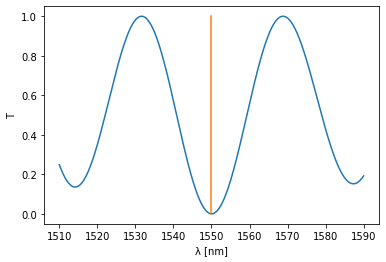

In [29]:
S = mzi(wl=wl, top={"length": 15.0 + delta_length}, btm={"length": 15.0})
plt.plot(wl * 1e3, abs(S["o1", "o4"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.plot([1550, 1550], [0, 1])
plt.show()

The minimum of the MZI is perfectly located at 1550nm.

## Model fit

You can fit a sax model to Sparameter FDTD simulation data.

In [30]:
import tqdm
import jax
import jax.numpy as jnp
import jax.example_libraries.optimizers as opt
import matplotlib.pyplot as plt

import gdsfactory as gf
import gdsfactory.simulation.modes as gm
import gdsfactory.simulation.sax as gs

In [31]:
gf.config.sparameters_path

PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp')

In [32]:
sd = gs.read.sdict_from_csv(
    gf.config.sparameters_path / "coupler" / "coupler_G224n_L20_S220.csv",
    xkey="wavelength_nm",
    prefix="S",
    xunits=1e-3,
)

In [33]:
coupler_fdtd = gf.partial(
    gs.read.sdict_from_csv,
    filepath=gf.config.sparameters_path / "coupler" / "coupler_G224n_L20_S220.csv",
    xkey="wavelength_nm",
    prefix="S",
    xunits=1e-3,
)

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

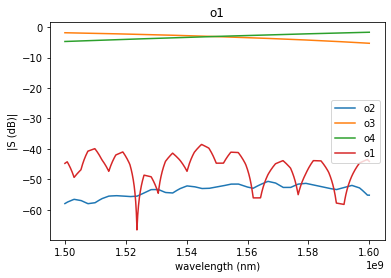

In [34]:
gs.plot_model(coupler_fdtd)

## Model fit (linear regression)

Lets fit the coupler spectrum with a linear regression `sklearn` fit

In [35]:
import sax
import gdsfactory as gf
import gdsfactory.simulation.sax as gs
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.constants import c
from sklearn.linear_model import LinearRegression

In [36]:
f = jnp.linspace(c / 1.0e-6, c / 2.0e-6, 500) * 1e-12  # THz
wl = c / (f * 1e12) * 1e6  # um

filepath = gf.config.sparameters_path / "coupler" / "coupler_G224n_L20_S220.csv"
coupler_fdtd = gf.partial(
    gs.read.sdict_from_csv, filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3
)
sd = coupler_fdtd(wl=wl)

k = sd["o1", "o3"]
t = sd["o1", "o4"]
s = t + k
a = t - k

Lets fit the symmetric (t+k) and antisymmetric (t-k) transmission

### Symmetric

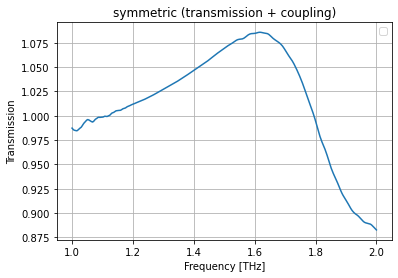

In [37]:
plt.plot(wl, jnp.abs(s))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title("symmetric (transmission + coupling)")
plt.legend()
plt.show()

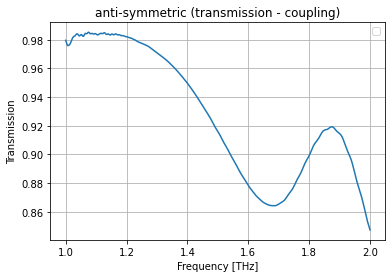

In [38]:
plt.plot(wl, jnp.abs(a))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title("anti-symmetric (transmission - coupling)")
plt.legend()
plt.show()

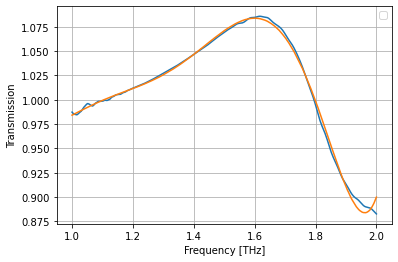

In [39]:
r = LinearRegression()
fX = lambda x, _order=8: x[:, None] ** (
    jnp.arange(_order)[None, :]
)  # artificially create more 'features' (wl**2, wl**3, wl**4, ...)
X = fX(wl)
r.fit(X, jnp.abs(s))
asm, bsm = r.coef_, r.intercept_
fsm = lambda x: fX(x) @ asm + bsm  # fit symmetric module fiir

plt.plot(wl, jnp.abs(s))
plt.plot(wl, fsm(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.legend()
plt.show()

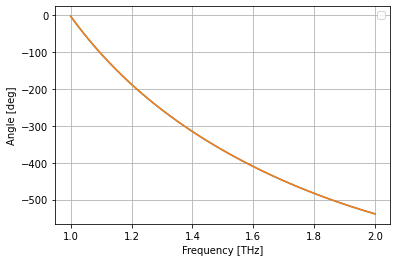

In [40]:
r = LinearRegression()
r.fit(X, jnp.unwrap(jnp.angle(s)))
asp, bsp = r.coef_, r.intercept_
fsp = lambda x: fX(x) @ asp + bsp  # fit symmetric phase

plt.plot(wl, jnp.unwrap(jnp.angle(s)))
plt.plot(wl, fsp(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Angle [deg]")
plt.legend()
plt.show()

In [41]:
fs = lambda x: fsm(x) * jnp.exp(1j * fsp(x))

Lets fit the symmetric (t+k) and antisymmetric (t-k) transmission

### Anti-Symmetric

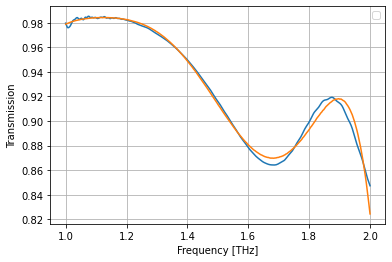

In [42]:
r = LinearRegression()
r.fit(X, jnp.abs(a))
aam, bam = r.coef_, r.intercept_
fam = lambda x: fX(x) @ aam + bam

plt.plot(wl, jnp.abs(a))
plt.plot(wl, fam(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.legend()
plt.show()

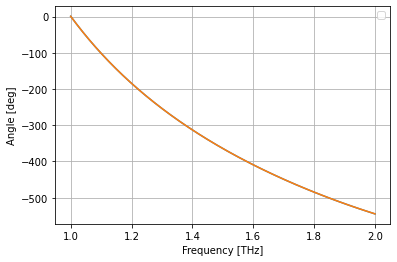

In [43]:
r = LinearRegression()
r.fit(X, jnp.unwrap(jnp.angle(a)))
aap, bap = r.coef_, r.intercept_
fap = lambda x: fX(x) @ aap + bap

plt.plot(wl, jnp.unwrap(jnp.angle(a)))
plt.plot(wl, fap(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Angle [deg]")
plt.legend()
plt.show()

In [44]:
fa = lambda x: fam(x) * jnp.exp(1j * fap(x))

### Total

Text(0, 0.5, 'Transmission')

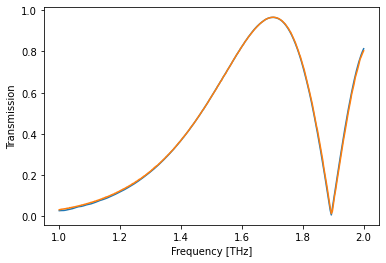

In [45]:
t_ = 0.5 * (fs(wl) + fa(wl))

plt.plot(wl, jnp.abs(t))
plt.plot(wl, jnp.abs(t_))
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")

Text(0, 0.5, 'Coupling')

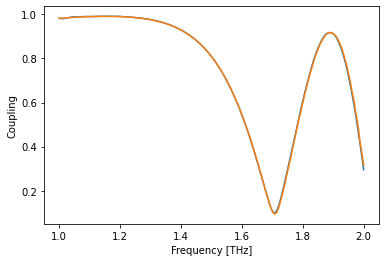

In [46]:
k_ = 0.5 * (fs(wl) - fa(wl))

plt.plot(wl, jnp.abs(k))
plt.plot(wl, jnp.abs(k_))
plt.xlabel("Frequency [THz]")
plt.ylabel("Coupling")

In [47]:
@jax.jit
def coupler(wl=1.5):
    wl = jnp.asarray(wl)
    wl_shape = wl.shape
    wl = wl.ravel()
    t = (0.5 * (fs(wl) + fa(wl))).reshape(*wl_shape)
    k = (0.5 * (fs(wl) - fa(wl))).reshape(*wl_shape)
    sdict = {
        ("o1", "o4"): t,
        ("o1", "o3"): k,
        ("o2", "o3"): k,
        ("o2", "o4"): t,
    }
    return sax.reciprocal(sdict)

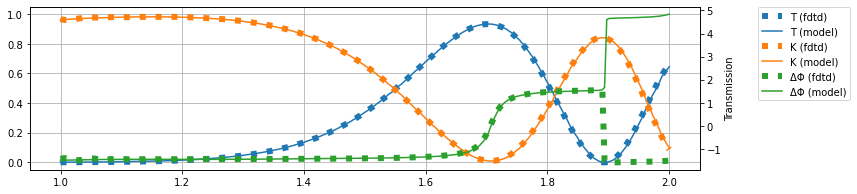

In [48]:
f = jnp.linspace(c / 1.0e-6, c / 2.0e-6, 500) * 1e-12  # THz
wl = c / (f * 1e12) * 1e6  # um

filepath = gf.config.sparameters_path / "coupler" / "coupler_G224n_L20_S220.csv"
coupler_fdtd = gf.partial(
    gs.read.sdict_from_csv, filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3
)
sd = coupler_fdtd(wl=wl)
sd_ = coupler(wl=wl)

T = jnp.abs(sd["o1", "o4"]) ** 2
K = jnp.abs(sd["o1", "o3"]) ** 2
T_ = jnp.abs(sd_["o1", "o4"]) ** 2
K_ = jnp.abs(sd_["o1", "o3"]) ** 2
dP = jnp.unwrap(jnp.angle(sd["o1", "o3"]) - jnp.angle(sd["o1", "o4"]))
dP_ = jnp.unwrap(jnp.angle(sd_["o1", "o3"]) - jnp.angle(sd_["o1", "o4"]))

plt.figure(figsize=(12, 3))
plt.plot(wl, T, label="T (fdtd)", c="C0", ls=":", lw="6")
plt.plot(wl, T_, label="T (model)", c="C0")

plt.plot(wl, K, label="K (fdtd)", c="C1", ls=":", lw="6")
plt.plot(wl, K_, label="K (model)", c="C1")

plt.ylim(-0.05, 1.05)
plt.grid(True)

plt.twinx()
plt.plot(wl, dP, label="ΔΦ (fdtd)", color="C2", ls=":", lw="6")
plt.plot(wl, dP_, label="ΔΦ (model)", color="C2")

plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.figlegend(bbox_to_anchor=(1.08, 0.9))
plt.savefig("fdtd_vs_model.png", bbox_inches="tight")
plt.show()

## SAX gdsfactory Compatibility
> From Layout to Circuit Model

If you define your SAX S parameter models for your components, you can directly simulate your circuits from gdsfactory

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from omegaconf import OmegaConf
import sax
from pprint import pprint

import gdsfactory as gf
from gdsfactory.get_netlist import get_netlist as _get_netlist

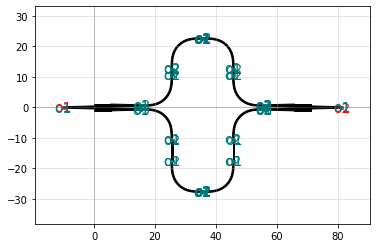

mzi_delta_length10: uid 6, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references

In [50]:
mzi = gf.components.mzi(delta_length=10)
mzi

In [51]:
netlist = mzi.get_netlist_dict()
pprint(netlist["connections"])

The netlist has three different components:

1. straight
2. mmi1x2
3. bend_euler

You need models for each subcomponents to simulate the Component.

In [52]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    wl0 = 1.5  # center wavelength for which the waveguide model is defined
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}

In [53]:
circuit = sax.circuit_from_netlist(
    netlist=netlist,
    models={
        "bend_euler": bend_euler,
        "mmi1x2": mmi1x2,
        "straight": straight,
    },
)

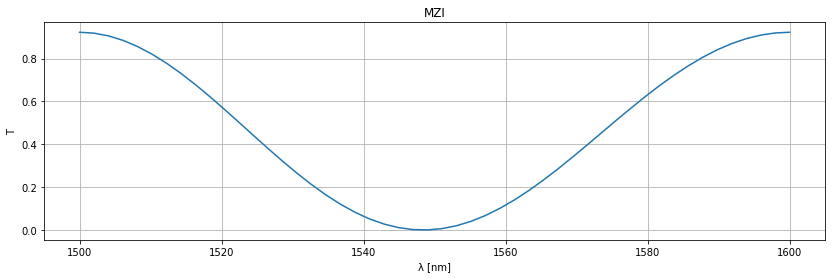

In [54]:
wl = np.linspace(1.5, 1.6)
S = circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

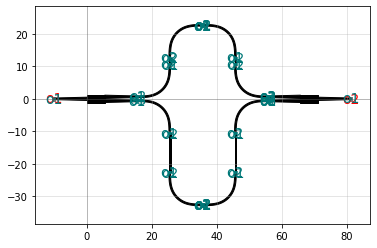

mzi_delta_length20: uid 20, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references

In [55]:
mzi = gf.components.mzi(delta_length=20)  # Double the length, reduces FSR by 1/2
mzi

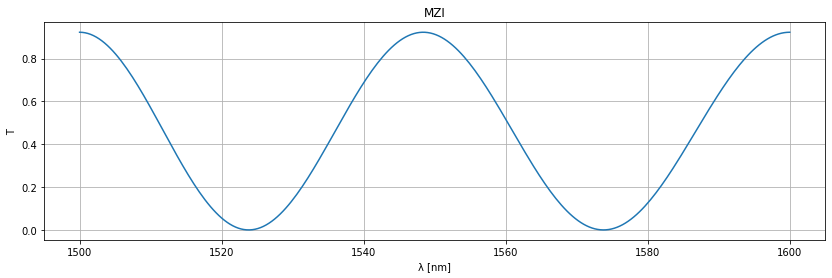

In [56]:
circuit = sax.circuit_from_netlist(
    netlist=mzi.get_netlist_dict(),
    models={
        "bend_euler": bend_euler,
        "mmi1x2": mmi1x2,
        "straight": straight,
    },
)

wl = np.linspace(1.5, 1.6, 256)
S = circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()